# Projeto 11: Rede Neural Convolucional MNIST

## Etapa 1: Importação das bibliotecas

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms


from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(42)
np.random.seed(42)

Mounted at /content/drive


## Etapa 2: Base dados

In [ ]:
transform = transforms.ToTensor() # faz download e normaliza dados
train = datasets.MNIST(root='/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep Learning com PyTorch/models', train=True, download=True, transform=transform)
test = datasets.MNIST(root='/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep Learning com PyTorch/models', train=False, download=True, transform=transform)

In [ ]:
train.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [ ]:
train.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

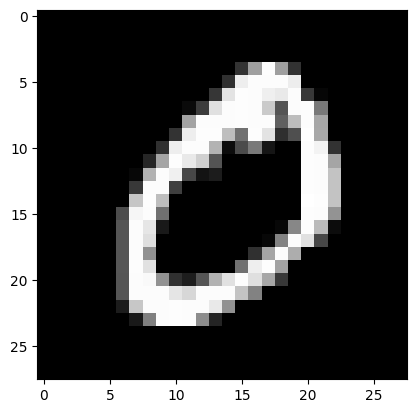

In [ ]:
imagem = next(iter(train_loader))[0][1].view(28,28) # 0 -> previsores e 1-> imagem 1
plt.imshow(imagem, cmap='gray')
plt.show()

In [ ]:
imagem.shape

torch.Size([28, 28])

(array([619.,  12.,  12.,  11.,   5.,   9.,  13.,  12.,  11.,  80.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

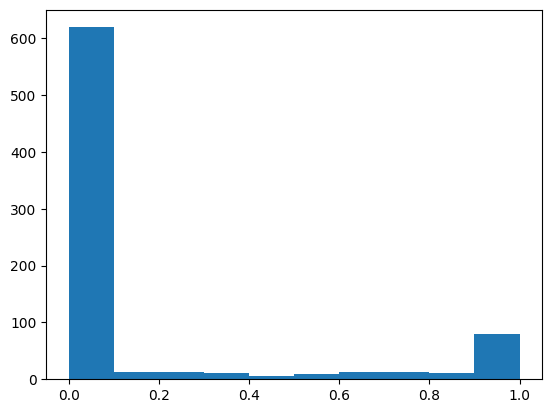

In [ ]:
plt.hist(imagem.view(-1)) # verificando que imagem está normalizada

## Etapa 3: Construção do modelo

In [ ]:
class classificador(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
    self.activation = nn.ReLU()
    self.bnorm1 = nn.BatchNorm2d(num_features=32)
    self.bnorm2 = nn.BatchNorm2d(num_features=64)
    self.poll = nn.MaxPool2d(kernel_size=(2, 2))
    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear(in_features=64*5*5, out_features=256)
    self.linear2 = nn.Linear(in_features=256, out_features=128)

    self.output = nn.Linear(in_features=128, out_features=10)

    self.dropout = nn.Dropout(p = 0.2)

    # output convolução = (input - kernel_size + 1) / stride
    # output pooling = input / 2

  def forward(self, X):

    X = self.conv1(X) # saida = (28 - 3 + 1) = (26, 26, 32)
    X = self.activation(X)
    X = self.bnorm1(X)
    X = self.poll(X) # saida = 26 / 2 = 13 = (13, 13, 32)

    X = self.conv2(X) # saida = 13 - 3 + 1 = (11, 11, 64)
    X = self.activation(X)
    X = self.bnorm2(X)
    X = self.poll(X) # saida = 11 / 2 = (5, 5, 64)

    X = self.flatten(X) # entrada (5,5) vezes 64 filtros da camada anterior

    X = self.linear1(X)
    X = self.activation(X)
    X = self.dropout(X)

    X = self.linear2(X)
    X = self.activation(X)
    X = self.dropout(X)

    X = self.output(X)

    return X



In [ ]:
net = classificador()
criterion = nn.CrossEntropyLoss() # faz aplicação do softmax automaticamente
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Etapa 4: Treinamento do modelo

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
device

device(type='cuda', index=0)

In [ ]:
def training_loop(loader, epoch):
  running_loss = 0.
  running_accuracy = 0.

  for i, data in enumerate(loader):
    inputs, labels = data

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs) # mesma coisa que net.foward(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    ps = F.softmax(outputs, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)

    accuracy = torch.mean(equals.type(torch.float))
    running_accuracy += accuracy.item()

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch+1, i+1, len(loader), loss, accuracy), end ='\r')

  print('\rÉpoca {:3d} finalizada: perda {:.5f} - precisão {:.5f}'. format(epoch+1, running_loss/len(loader), running_accuracy/len(loader)))



In [ ]:
for epoch in range(5):
  print('Treinando ...')
  net.train()
  training_loop(train_loader, epoch)

  print('Validando ...')
  net.eval()
  training_loop(test_loader, epoch)


Treinando ...
Época   1 finalizada: perda 0.12652 - precisão 0.96153
Validando ...
Época   1 finalizada: perda 0.05128 - precisão 0.98447
Treinando ...
Época   2 finalizada: perda 0.04422 - precisão 0.98703
Validando ...
Época   2 finalizada: perda 0.02310 - precisão 0.99219
Treinando ...
Época   3 finalizada: perda 0.02905 - precisão 0.99097
Validando ...
Época   3 finalizada: perda 0.01803 - precisão 0.99397
Treinando ...
Época   4 finalizada: perda 0.02302 - precisão 0.99273
Validando ...
Época   4 finalizada: perda 0.01380 - precisão 0.99377
Treinando ...
Época   5 finalizada: perda 0.01693 - precisão 0.99476
Validando ...
Época   5 finalizada: perda 0.01092 - precisão 0.99654


## Etapa 5: Avaliação do modelo

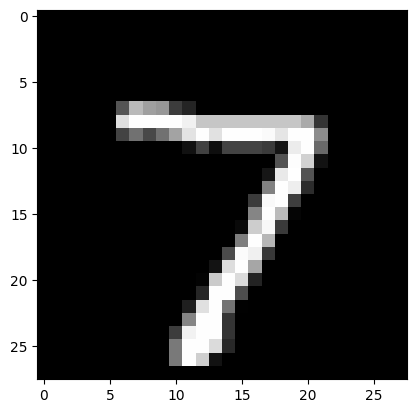

In [ ]:
imagem = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(imagem, cmap='gray')
plt.show()

In [ ]:
imagem = imagem.view(1,1,28,28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [ ]:
net.eval()
imagem = imagem.to(device)
pred = net(imagem)
pred

tensor([[ -9.4239,  -1.6194,  -2.5279,  -4.4757,   1.0821,  -6.3953, -13.6731,
          17.1846,  -7.9844,   1.5259]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
pred = F.softmax(pred, dim=1)
pred

tensor([[2.7802e-12, 6.8160e-09, 2.7479e-09, 3.9180e-10, 1.0158e-07, 5.7461e-11,
         3.9690e-14, 1.0000e+00, 1.1729e-11, 1.5832e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
pred = pred.cpu().detach().numpy()
resultado = np.argmax(pred)
resultado

7

Vou tentar passar uma imagem real para ver se ele reconhece.



In [ ]:
import os
import numpy as np
from PIL import Image

def load_and_convert_images(folder_path, image_names, size):
    images = []
    for img_name in image_names:
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert("L")  # Converte para preto e branco
        img = img.resize(size)  # Redimensiona para o tamanho especificado
        img_array = np.array(img)  # Converte para array numpy
        img_array = 255 - img_array  # Inverte as cores (negativo da imagem)
        images.append(img_array)
    return images


folder_path = "/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep Learning com PyTorch/data"  # Caminho da pasta com as imagens
image_names = ["IMG_4300.JPG", "IMG_4301.JPG"]  # Nomes das imagens
desired_size = (28, 28)  # Tamanho desejado para as imagens

images_np = load_and_convert_images(folder_path, image_names, desired_size)

# Exibir as formas dos arrays
for i, img_array in enumerate(images_np):
    print(f"Imagem {i+1} - Shape: {img_array.shape}")

Imagem 1 - Shape: (28, 28)
Imagem 2 - Shape: (28, 28)


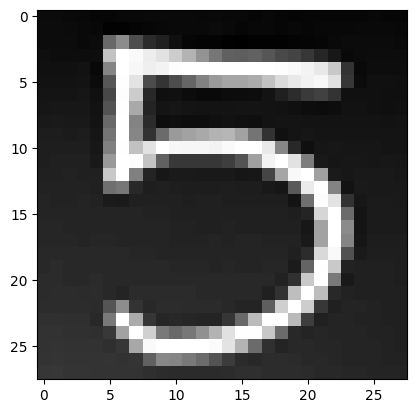

In [ ]:
plt.imshow(images_np[0], cmap='gray')
plt.show()

In [ ]:
teste = torch.tensor(np.array(images_np), dtype=torch.float)
teste.shape


torch.Size([2, 28, 28])

In [ ]:
img0 = teste[0]
img1 = teste[1]

img0.shape, img1.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

In [ ]:
img0 = img0.view(1,1,28,28)
img1 = img1.view(1,1,28,28)

img0.shape, img1.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 1, 28, 28]))

In [ ]:
img0 = img0.to(device)
pred = net(img0)
pred = F.softmax(pred, dim=1)
pred = pred.cpu().detach().numpy()
resultado = np.argmax(pred)
resultado

5

In [ ]:
img1 = img1.to(device)
pred = net(img1)
pred = F.softmax(pred, dim=1)
pred = pred.cpu().detach().numpy()
resultado = np.argmax(pred)
pred, resultado

(array([[0.0000000e+00, 0.0000000e+00, 4.8206675e-11, 0.0000000e+00,
         4.5216931e-11, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.0000000e+00, 0.0000000e+00]], dtype=float32),
 8)

Errou o 7, mas acertou o 5. Mas provavelmente errou o 7 pela minha diferente caligrafia.

# Projeto 13: Rede Neural Convolution MNIST com Data Augmentation

## Etapa 1: Importação dos dados

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(42)
np.random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Etapa 2: Base de dados

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=7,
                           translate=(0, 0.7), # horizontal and vertical shifts
                           shear = 7,
                           scale=(1, 1.2)
                           ), # zoom range
    transforms.ToTensor()
])

In [4]:
transforms_test = transforms.ToTensor()

In [5]:
train = datasets.MNIST(root='', train=True, download=True, transform=transform_train)
test = datasets.MNIST(root='', train=False, download=True, transform=transforms_test)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.0MB/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.14MB/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [6]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

## Etapa 3: Construção do modelo

In [7]:
class classificador(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.activation = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=32*13*13, out_features=128)
    self.output = nn.Linear(in_features=128, out_features=10)

  def forward(self, X):
    X = self.pool(self.activation(self.conv(X)))
    X = self.flatten(X)
    X = self.activation(self.linear(X))
    X = self.output(X)
    return X

In [8]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
device

device(type='cpu')

In [10]:
net.to(device)

classificador(
  (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=5408, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

## Etapa 4: Treinamento do modelo

In [11]:
def training_loop(loader, epoch):
  running_loss = 0.
  running_accuracy = 0.

  for i, data in enumerate(loader):
    inputs, labels = data

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs) # mesma coisa que net.foward(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    ps = F.softmax(outputs, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)

    accuracy = torch.mean(equals.type(torch.float))
    running_accuracy += accuracy.item()

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch+1, i+1, len(loader), loss, accuracy), end ='\r')

  print('\rÉpoca {:3d} finalizada: perda {:.5f} - precisão {:.5f}'. format(epoch+1, running_loss/len(loader), running_accuracy/len(loader)))



In [12]:
for epoch in range(5):
  print('Treinando ...')
  net.train()
  training_loop(train_loader, epoch)

  print('Validando ...')
  net.eval()
  training_loop(test_loader, epoch)


Treinando ...
Época   1 finalizada: perda 1.66161 - precisão 0.41003
Validando ...
Época   1 finalizada: perda 0.38518 - precisão 0.88004
Treinando ...
Época   2 finalizada: perda 1.10526 - precisão 0.61752
Validando ...
Época   2 finalizada: perda 0.25898 - precisão 0.91950
Treinando ...
Época   3 finalizada: perda 0.92712 - precisão 0.67814
Validando ...
Época   3 finalizada: perda 0.20514 - precisão 0.93790
Treinando ...
Época   4 finalizada: perda 0.84593 - precisão 0.70560
Validando ...
Época   4 finalizada: perda 0.16422 - precisão 0.94966
Treinando ...
Época   5 finalizada: perda 0.77400 - precisão 0.72867
Validando ...
Época   5 finalizada: perda 0.13746 - precisão 0.96044


# Projeto 14: Rede Neural Convolucional Gatos e Cachorros

## Etapa 1: Importação das bibliotecas

In [13]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
import torch.nn as nn
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
torch.manual_seed(42)
np.random.seed(42)

## Etapa 2: Construção do modelo

In [15]:
classificador = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=32),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=32),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=14*14*32, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=1),
    nn.Sigmoid()
)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

## Etapa 3: Base de dados

In [16]:
path = '/content/drive/Othercomputers/LorranGalaxy/Cursos/Deep Learning com PyTorch/Bases/Bases/dataset.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [17]:
data_dir_train = '/content/dataset/training_set'
data_dir_test = '/content/dataset/test_set'

In [18]:
transform_train = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=7,
                           translate=(0, 0.7), # horizontal and vertical shifts
                           shear = 0.2,
                           scale=(1, 1.2)
                           ), # zoom range
    transforms.ToTensor()
])

In [19]:
transform_test = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.ToTensor()
])

In [20]:
train_dataset = datasets.ImageFolder(root=data_dir_train, transform=transform_train)
test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform_test)

In [21]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /content/dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.7), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

## Etapa 4: Treinamento do modelo

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classificador.to(device)
device

device(type='cpu')

In [28]:
def training_loop(loader, epoch):
  running_loss = 0.
  running_accuracy = 0.

  for i, data in enumerate(loader):
    inputs, labels = data

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = classificador(inputs) # mesma coisa que net.foward(inputs)

    loss = criterion(outputs, labels.float().view(*outputs.shape))
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    predicted = torch.tensor([1 if x > 0.5 else 0 for x in outputs]).to(device)
    equals = predicted == labels.view(*predicted.shape)

    accuracy = torch.mean(equals.float())
    running_accuracy += accuracy.item()

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch+1, i+1, len(loader), loss, accuracy), end ='\r')
  print('\rÉpoca {:3d} finalizada: perda {:.5f} - precisão {:.5f}'. format(epoch+1, running_loss/len(loader), running_accuracy/len(loader)))

In [29]:
for epoch in range(10):
  print('Treinando ...')
  classificador.train()
  training_loop(train_loader, epoch)

  print('Validando ...')
  classificador.eval()
  training_loop(test_loader, epoch)

Treinando ...
Época   1 finalizada: perda 0.00000 - precisão 0.50125
Validando ...
Época   1 finalizada: perda 0.00000 - precisão 0.49512
Treinando ...
Época   2 finalizada: perda 0.00000 - precisão 0.50000
Validando ...
Época   2 finalizada: perda 0.00000 - precisão 0.49023
Treinando ...
Época   3 finalizada: perda 0.00000 - precisão 0.50375
Validando ...
Época   3 finalizada: perda 0.00000 - precisão 0.49023
Treinando ...
Época   4 finalizada: perda 0.00000 - precisão 0.49050
Validando ...
Época   4 finalizada: perda 0.00000 - precisão 0.49902
Treinando ...
Época   5 finalizada: perda 0.00000 - precisão 0.49750
Validando ...
Época   5 finalizada: perda 0.00000 - precisão 0.49707
Treinando ...
Época   6 finalizada: perda 0.00000 - precisão 0.49925
Validando ...
Época   6 finalizada: perda 0.00000 - precisão 0.50000
Treinando ...
Época   7 finalizada: perda 0.00000 - precisão 0.49850
Validando ...
Época   7 finalizada: perda 0.00000 - precisão 0.49609
Treinando ...
Época   8 finalizada

## Etapa 5: Avaliação do modelo

In [35]:
def classificar_imagem(fname):
  from PIL import Image
  import matplotlib.pyplot as plt

  imagem_teste = Image.open(data_dir_test + '/' + fname)
  plt.imshow(imagem_teste)
  plt.show()

  import numpy as np
  imagem_teste = imagem_teste.resize((64,64))
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
  imagem_teste = imagem_teste / 255
  imagem_teste = np.transpose(imagem_teste, (2,0,1))
  imagem_teste = torch.tensor(imagem_teste, dtype = torch.float).view(-1, *imagem_teste.shape)

  classificador.eval()
  imagem_teste = imagem_teste.to(device)
  pred = classificador(imagem_teste)

  if pred > 0.5:
    output = 1
  else:
    output = 0

  idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
  print('Classe :', idx_to_class[output])


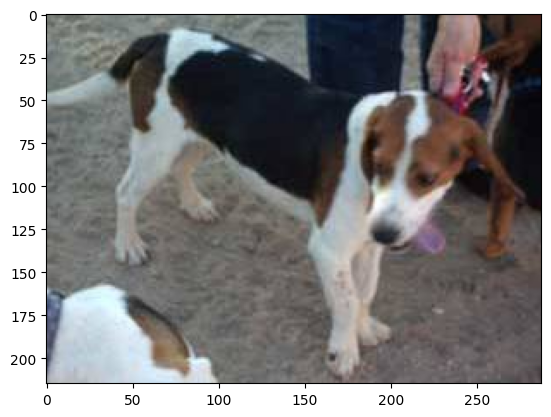

Previsão : 0
Classe : cachorro


'cachorro'

In [33]:
imagem = 'cachorro/dog.3500.jpg'
classificar_imagem(imagem)

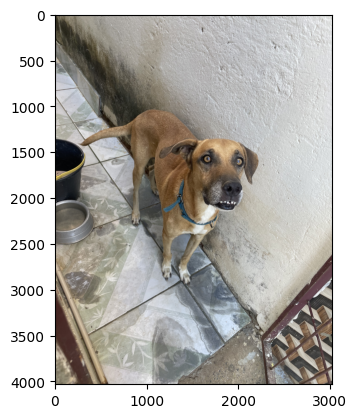

Classe : cachorro


In [36]:
imagem = 'cachorro/IMG_4398.jpg'
classificar_imagem(imagem)